In [1]:
using CairoMakie
using FourierFlows
using JLD2
using Printf
using StatsBase
include("../AnalysisUtils.jl")

mapfilter_snapshots (generic function with 1 method)

In [38]:
function find_max_u(directory)
    params = read_swqg_params(directory, "swqg")
    nx, Lx = get_grid_size(directory, "swqg")
    grid = TwoDGrid(; nx, Lx)
    
    filename_func(idx) = @sprintf("%s/swqg.%06d.jld2", directory, idx)
    num_files = sum([1 for file in readdir(directory) if occursin("swqg.", file)])-1
    file_idx = 1
    ψh = zeros(Complex{Float64}, grid.nkr, grid.nl, 2)

    umax = 0
    max_index = 0
    max_time = 0
    cur_idx = 2
    for j=0:num_files
        file = jldopen(filename_func(j))
        for key=keys(file["snapshots/t"])[end-100:10:end]
            t = file["snapshots/t/" * key]
            qh = file["snapshots/sol/" * key]
            @. ψh = -qh/(grid.Krsq + params.Kd2)
            uh =  -grid.l  .* ψh
            vh =   grid.kr .* ψh
            u = irfft(uh, grid.nx)
            v = irfft(vh, grid.nx)
            max_speed = sqrt.(maximum(u.^2 + v.^2))
            if max_speed >= umax
                umax = max_speed
                max_index = cur_idx
                max_time = t
            end
            cur_idx += 1
        end
        close(file)
    end
    return umax, max_index, max_time
end

function compute_avg_diffusion(directory, offset, Nsnapshots)
    t2, _, k2, _ = load_snapshot(directory, Nsnapshots)
    b = 0.0
    for i=1:offset
        t1, _, k1, up = load_snapshot(directory, Nsnapshots - i)
        dt = t2 - t1

        K1 = sqrt.(k1[:,1].^2 + k1[:,2].^2)
        K2 = sqrt.(k2[:,1].^2 + k2[:,2].^2)
        mask = isfinite.(K2) .& isfinite.(K1)
        
        b += sum((K2[mask] - K1[mask]).^2) / sum(2 * K1.^2 * dt)

        t2 = t1
        k2 = k1
    end
    return b / offset
end

function compute_GBM_parameters(directory, Nsnapshots, offset)
    _, _, k0, _ = load_snapshot(directory, 1)
    t0, _, _, _ = load_snapshot(directory, 2)

    drift = 0.0
    diffusion = 0.0
    for i=0:(offset-1)
        t, _, k, _ = load_snapshot(directory, Nsnapshots-i)
    
        Δt = t - t0
        K0 = mean(sqrt.(k0[:,1].^2 + k0[:,2].^2))
        K = sqrt.(k[:,1].^2 + k[:,2].^2)
        mean_K = mean(K)
        var_K = var(K)
        
        drift += (log(mean_K/K0)/(Δt))
        diffusion += (log(var_K/(K0^2 * exp(2*drift.*Δt)) .+ 1) ./ (Δt))
    end
    return drift/offset, diffusion/offset
end

compute_GBM_parameters (generic function with 2 methods)

In [57]:
#predicate = "/scratch/nad9961/swqg/"
predicate = "/scratch/nad9961/twolayer_rays/"
froude_number = []
max_x_froude_number = []
max_xt_froude_number = []
max_ts = []
f0s = []
ωs = []
median_ωs = []
mean_diffusion = []
drift = []
diffusion = []
qs = []
for line=readlines("raytracing-runs-two-layer.txt")
    run_directory = predicate * line
    f0, Cg = read_parameters(run_directory)
    nx, Lx = get_grid_size(run_directory, "2Lqg")
    grid = TwoDGrid(;nx, Lx)
    Nsnapshots = floor(Int, count_snapshots(run_directory))
    Nqg_snapshots = count_key_snapshots(run_directory, "2Lqg")
    _, _, k0, _ = load_snapshot(run_directory, 1)
    t0, _, k0, _ = load_snapshot(run_directory, 2)
    t, _, k, up = load_snapshot(run_directory, Nsnapshots)
    
    #b = compute_avg_diffusion(run_directory, 1, Nsnapshots)
    K = sqrt.(k[:,1].^2 + k[:,2].^2)
    K0 = sqrt.(k0[:,1].^2 + k0[:,2].^2)
    mask = isfinite.(K)
    mean_K = mean(K[mask])
    var_K = var(K[mask])
    mean_K0 = mean(K0[mask])

    μ, σ2 = compute_GBM_parameters(run_directory, Nsnapshots, 1)
    #μ = log(mean_K / mean_K0)/(t - t0)
    #σ = sqrt(log(var_K / (mean_K0^2*exp(2 * μ * (t - t0))) + 1) / (t-t0))
    b = μ / 3
    σ = sqrt(σ2)
    
    _, qh = load_key_snapshot(run_directory, "2Lqg", Nqg_snapshots)
    params = read_2Lqg_params(run_directory, "2Lqg")
    
    qch = 0.5 * (qh[:,:,1] - qh[:,:,2])
    ψch = -qch ./ (grid.Krsq .+ 2*params.F)
    uch = -1im * grid.l  .* ψch
    vch =  1im * grid.kr .* ψch
    
    u = irfft(uch, grid.nx)
    v = irfft(vch, grid.nx)
    
    rms_u = sqrt.(sum(u.^2 + v.^2)/grid.nx/grid.ny)
    rms_up = sqrt.(sum(up[:,1].^2 + up[:,2].^2)/size(up, 1))
    rms_up = mean(sqrt.(up[:,1].^2 + up[:,2].^2))
    u_max_x = maximum(sqrt.(u.^2 + v.^2))
    #u_max_xt, max_index, max_time = find_max_u(run_directory)
    ω = compute_ω(k, f0, Cg)
    mean_ω = mean(ω[isfinite.(ω)])
    median_ω = median(ω[isfinite.(ω)])
    println(@sprintf("dir: %s, Umax_x: %0.4f, Urms: %0.4f Uprms: %0.4f, Cg: %0.2f, mean ω: %0.1f, Fr: %0.3f, Lx=%0.0fπ", line, u_max_x, rms_u, rms_up, Cg, mean_ω, rms_u/Cg, Lx/π))
    push!(max_x_froude_number, u_max_x / Cg)
    #push!(max_xt_froude_number, u_max_xt / Cg)
    push!(froude_number, rms_u / Cg)
    push!(ωs, mean_ω)
    push!(f0s, f0)
    push!(max_ts, t)
    push!(median_ωs, median_ω)
    #push!(qs, q)
    push!(mean_diffusion, b)
    push!(drift, μ)
    push!(diffusion, σ)
end

dir: 1542998/8, Umax_x: 0.0510, Urms: 0.0130 Uprms: 0.0111, Cg: 1.00, mean ω: 3.6, Fr: 0.013, Lx=2π
dir: 1542998/9, Umax_x: 0.1034, Urms: 0.0325 Uprms: 0.0280, Cg: 1.00, mean ω: 3.7, Fr: 0.032, Lx=2π
dir: 1542998/10, Umax_x: 0.2382, Urms: 0.0524 Uprms: 0.0447, Cg: 1.00, mean ω: 4.8, Fr: 0.052, Lx=2π
dir: 1554309/1, Umax_x: 0.0293, Urms: 0.0075 Uprms: 0.0064, Cg: 1.00, mean ω: 3.6, Fr: 0.008, Lx=2π
dir: 1554309/2, Umax_x: 0.0601, Urms: 0.0166 Uprms: 0.0143, Cg: 1.00, mean ω: 3.6, Fr: 0.017, Lx=2π
dir: 1554309/3, Umax_x: 0.1073, Urms: 0.0270 Uprms: 0.0218, Cg: 1.00, mean ω: 4.0, Fr: 0.027, Lx=2π
dir: 1554309/4, Umax_x: 0.1236, Urms: 0.0413 Uprms: 0.0351, Cg: 1.00, mean ω: 6.1, Fr: 0.041, Lx=2π
dir: 1554309/5, Umax_x: 0.1563, Urms: 0.0495 Uprms: 0.0419, Cg: 1.00, mean ω: 14.5, Fr: 0.049, Lx=2π
dir: 1554309/6, Umax_x: 0.2175, Urms: 0.0761 Uprms: 0.0664, Cg: 1.00, mean ω: 11301.5, Fr: 0.076, Lx=2π
dir: 1554309/7, Umax_x: 0.3120, Urms: 0.1056 Uprms: 0.0896, Cg: 1.00, mean ω: 3753573478.0, Fr

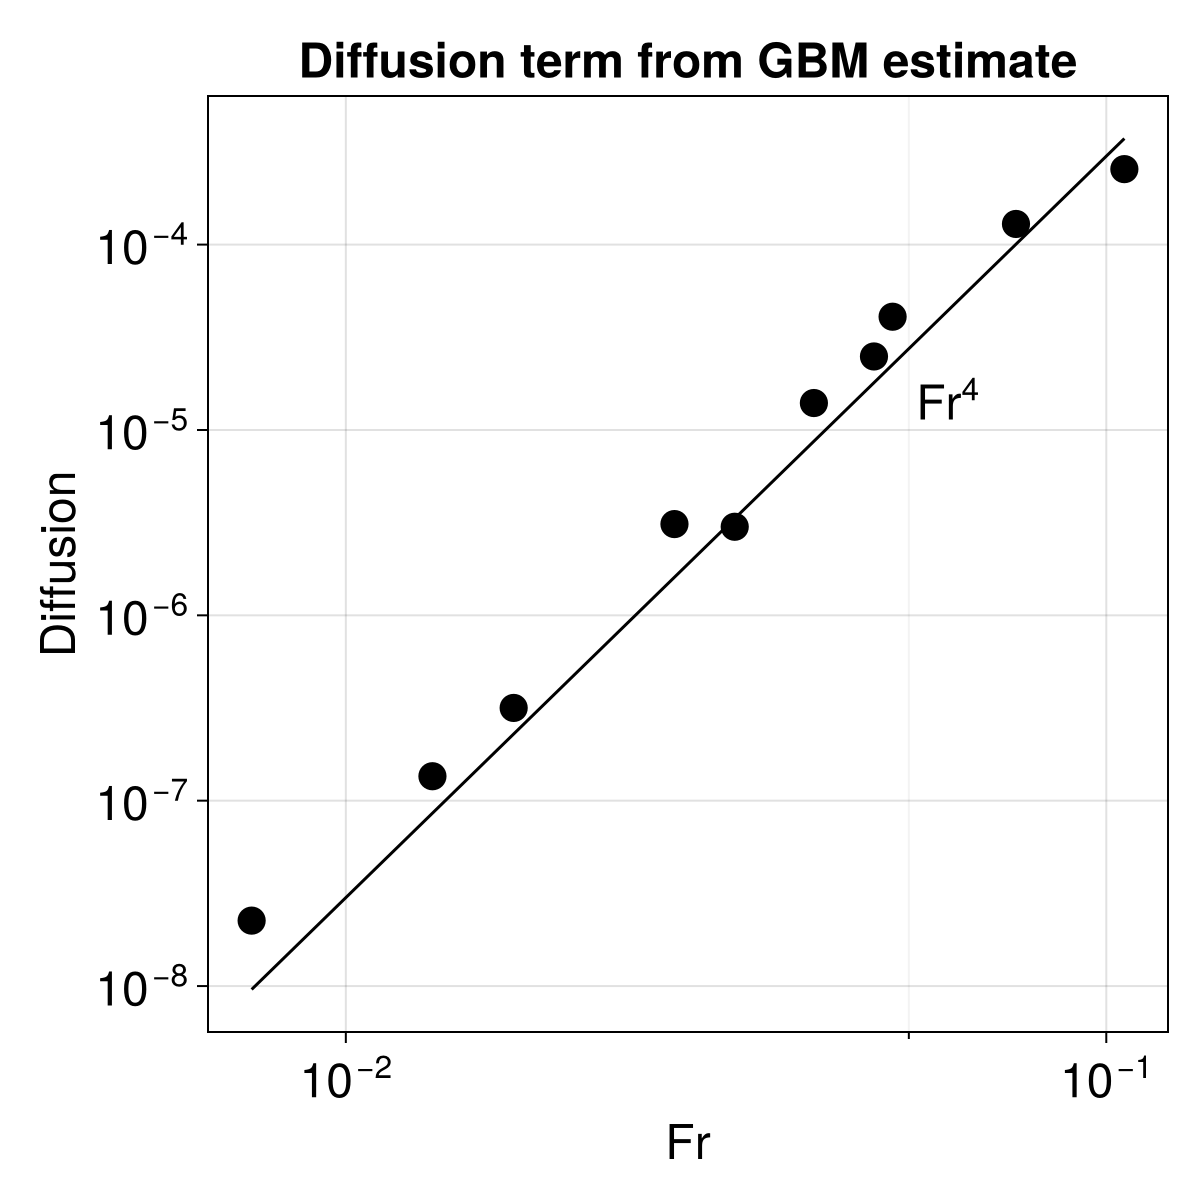

In [86]:
fig = Figure(size=(600, 600), fontsize=24)
ax = Axis(fig[1,1]; xscale=log10, yscale=log10, xlabel="Fr", ylabel=rich("Diffusion"), title="Diffusion term from GBM estimate",
    xticks=LogTicks(WilkinsonTicks(2; k_max=2)),
    xminorticksvisible=true,
    xminorgridvisible=true,
    xminorticks) #title=rich("Median frequency vs Fr", subscript("rms")))
scatter!(ax, froude_number, drift/3, markersize=20, color=:black)
#scatter!(ax, froude_number, drift/3,  color=:black)
#scatter!(ax, froude_number, diffusion.^2/2, color=:blue)
#scatter!(ax, froude_number, diffusion,  color=:red)
#scatter!(ax, froude_number, sqrt.(2*drift/3), marker='x', color=:red)
#lines!(ax, froude_number, mean_diffusion[4]/65536 * (froude_number/froude_number[4]).^2)
#lines!(ax, froude_number, drift[3] * (froude_number/froude_number[3]).^2.5)
lines!(ax, froude_number, 3*froude_number.^4, linestyle=:solid, color=:black)
text!(ax, 10^(-1.25), 1e-5; text=rich("Fr", superscript("4")))
#scatter!(ax, froude_number, ωs./f0s, markersize=12, color=:red)

#save("images/froude_number_vs_median_freq.eps", fig)
fig

In [40]:
1+1

2

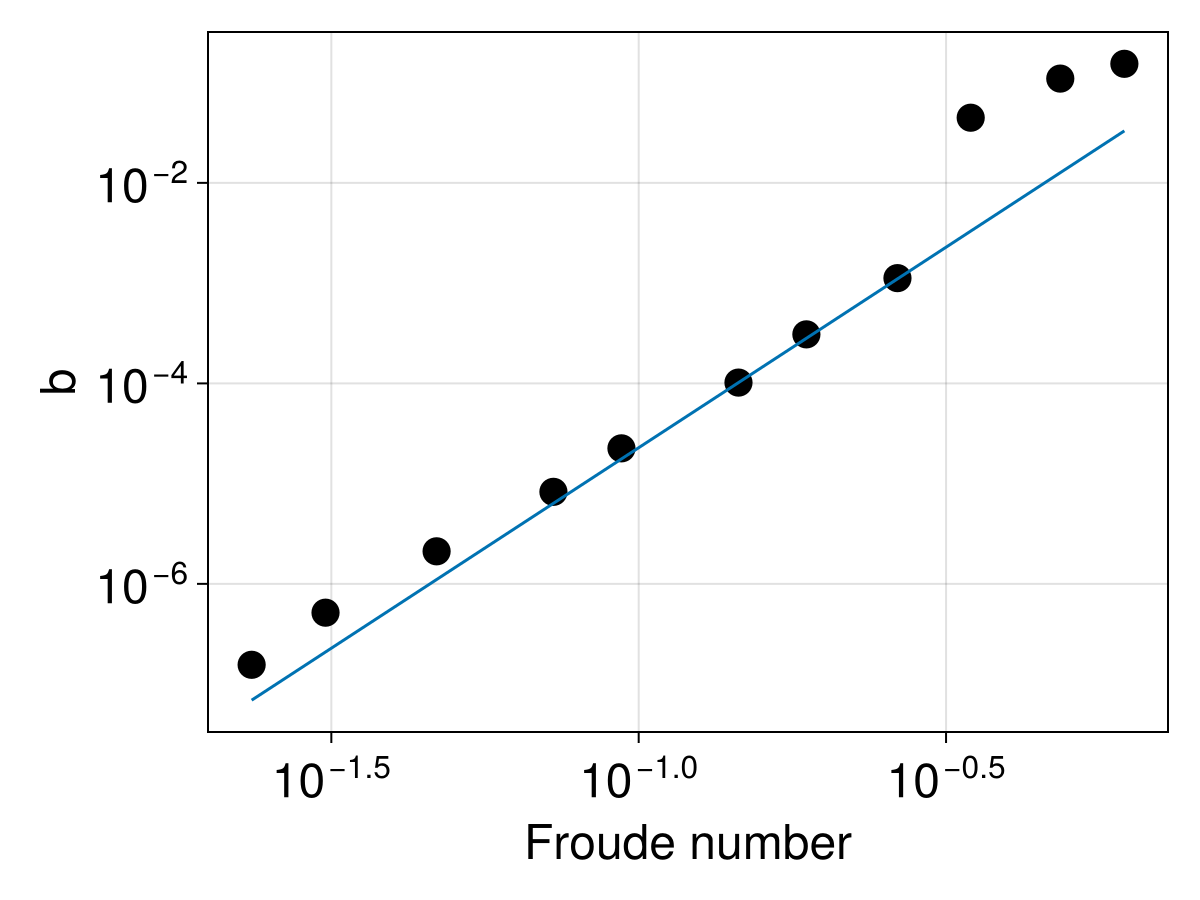

In [85]:
fig = Figure(fontsize=24)
ax = Axis(fig[1,1]; xscale=log10, yscale=log10, xlabel="Froude number", ylabel=rich("b")) #title=rich("Median frequency vs Fr", subscript("rms")))
scatter!(ax, froude_number, mean_diffusion, markersize=20, color=:black)
#lines!(ax, froude_number, mean_diffusion[4]/65536 * (froude_number/froude_number[4]).^2)
lines!(ax, froude_number, mean_diffusion[6] * (froude_number/froude_number[6]).^4)
#lines!(ax, froude_number, froude_number.^4, linestyle=:dash, color=:black)
#scatter!(ax, froude_number, ωs./f0s, markersize=12, color=:red)

#save("images/froude_number_vs_median_freq.eps", fig)
fig

In [10]:
fig = Figure(fontsize=24)
ax = Axis(fig[1,1]; yscale=log10, xlabel=rich("max", subscript("x,t"), "|u| / C",subscript("g")), ylabel=rich("mean ω"), title=rich("Mean frequency vs Fr", subscript("max")))
scatter!(ax, max_froude_number, median_ωs, markersize=12, color=:black)

fig

LoadError: UndefVarError: `max_froude_number` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

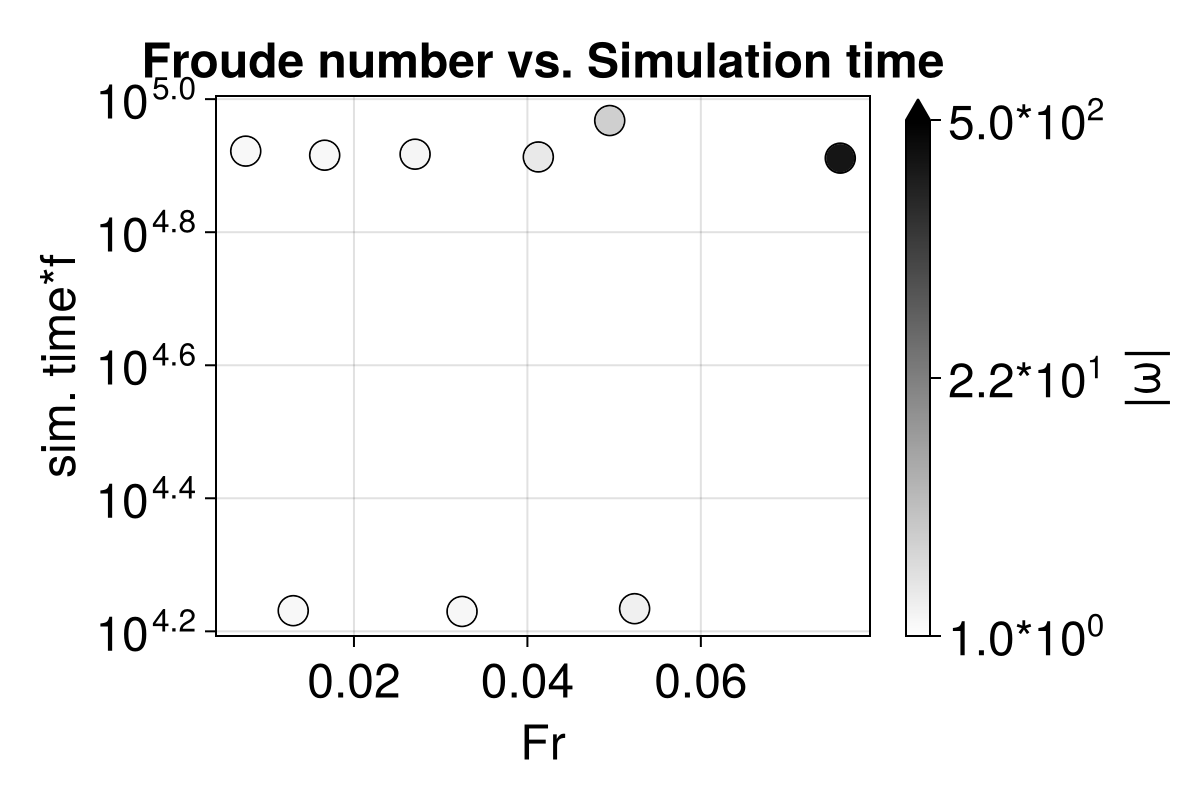

In [28]:
function to_scientific(val)
    power = floor(Int, log10.(val))
    mantissa = val / 10^power
    return rich(@sprintf("%0.1f*10", mantissa), superscript(@sprintf("%d", power)))
end

fig = Figure(size=(600, 400), fontsize=24)
ax = Axis(fig[1,1]; yscale=log10, xlabel="Fr", ylabel="sim. time*f", title="Froude number vs. Simulation time")
cutoff = 500
colors = 0.5*(log.(median_ωs./f0s)/log(cutoff)) .+ 0.5
tick_vals = [0.5, 0.75, 1.0]
tick_label_vals = exp.(2*(tick_vals .- 0.5)*log(cutoff))
tick_labels = [to_scientific(label_val) for label_val=tick_label_vals]
scatter!(ax, froude_number, max_ts.*f0s, markersize=21, color=:transparent, strokewidth=1, strokecolor=:black)
sc = scatter!(ax, froude_number, max_ts.*f0s, markersize=20, colorrange=(0.5, 1.0), highclip=:black, colormap=:binary, color=colors)
Colorbar(fig[1,2], sc; label="|ω|", ticks=(tick_vals, tick_labels))

fig

In [107]:
run_directory = "/scratch/nad9961/swqg/3288403/4"
f0, Cg = read_parameters(run_directory)
nx, Lx = get_grid_size(run_directory, "swqg")
grid = TwoDGrid(;nx, Lx)
Nsnapshots = count_snapshots(run_directory)
Nqg_snapshots = count_key_snapshots(run_directory, "swqg")
t, _, k, up = load_snapshot(run_directory, Nsnapshots)
t, q, _, u, v, _  = load_qgsw_snapshot(run_directory, grid, Nqg_snapshots)
rms_u = sqrt.(sum(u.^2 + v.^2) * (grid.dx * grid.dy) / grid.Lx/grid.Ly) * (grid.Lx/(2π))^2
ω = compute_ω(k, f0, Cg)
mean_ω = mean(ω[isfinite.(ω)])
median_ω = median(ω[isfinite.(ω)])


Any[]

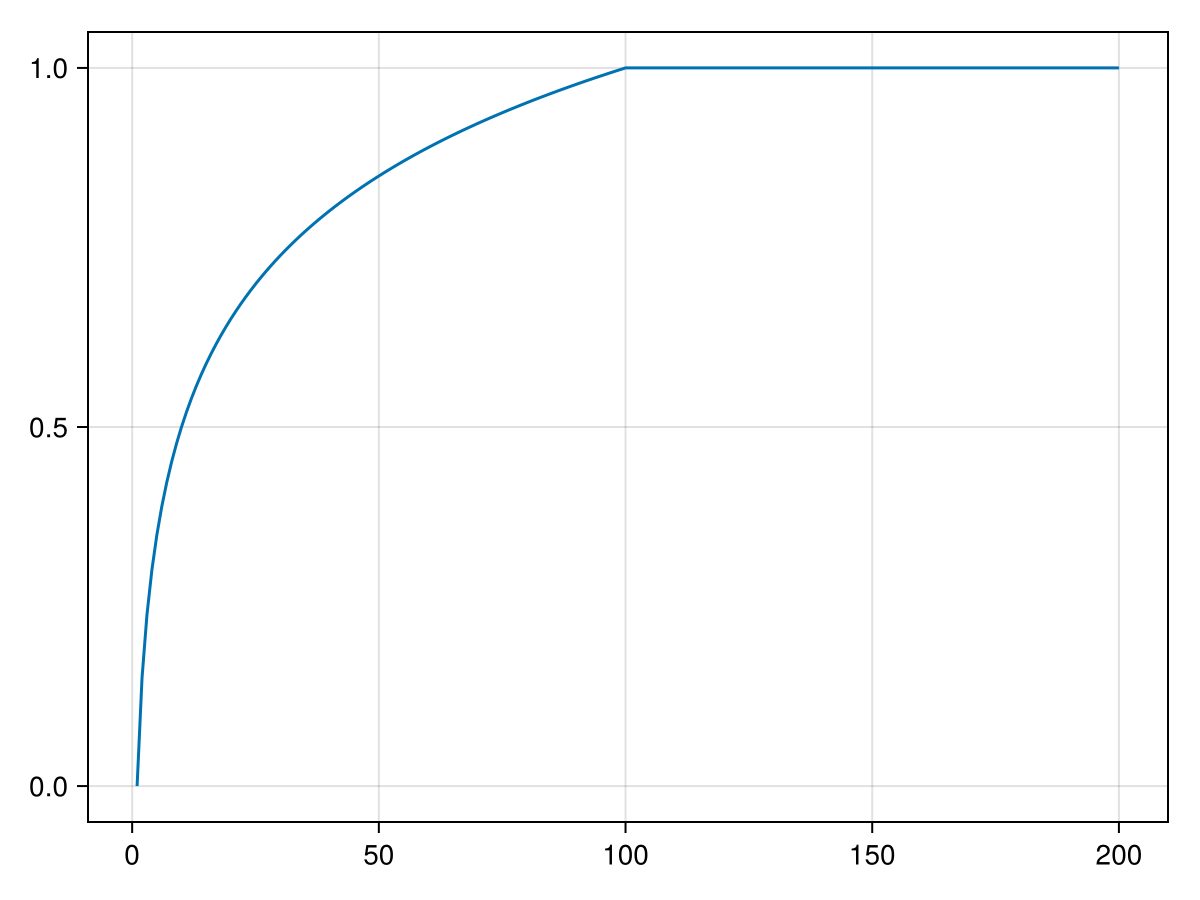

In [45]:
function color_gen(ω, cutoff)
    # If ω = 1: 0
    # If ω >= cutoff: 1
    # Logarithmic inbetween
    return log.(min.(ω, cutoff))/log(cutoff)
end

x = 1:200
cutoff = 100
lines(x, color_gen(x, cutoff))

In [36]:
color_gen(200, 200)

0.84122743555108

In [39]:
min.(1, log.(200/200))

0.0

In [29]:
weird_directory = "/scratch/nad9961/swqg/60202002/7/"
f0, Cg = read_parameters(weird_directory)
nx, Lx = get_grid_size(weird_directory, "swqg")
println(Lx)
grid = TwoDGrid(;nx, Lx)
t, q, ψ, u, v, Kd2 = load_qgsw_snapshot(weird_directory, grid, 3)
rms_vel = sqrt.(sum(u.^2 + v.^2)*grid.dx*grid.dy)
maximum(rms_vel / Cg)

18.849556


2.1028521064362735

In [31]:
median(sqrt.(u.^2 + v.^2))

0.09141794169705393

In [ ]:
grid =

In [20]:
100 ./ exp.(log(0.1):0.3:log(10.0))

16-element Vector{Float64}:
 999.9999999999998
 740.8182206817178
 548.8116360940263
 406.56965974059904
 301.19421191220204
 223.13016014842978
 165.29888822158654
 122.45642825298188
  90.71795328941249
  67.20551273974976
  49.78706836786393
  36.88316740124
  27.323722447292564
  20.241911445804387
  14.9955768204777
  11.108996538242305

In [24]:
200 ./ [0.1, 0.13, 0.2, 0.3, 0.4, 0.6, 0.8, 1.1, 1.5, 2.0, 2.7, 3.7, 4.9, 6.7, 9.0, 12.2]

16-element Vector{Float64}:
 2000.0
 1538.4615384615383
 1000.0
  666.6666666666667
  500.0
  333.33333333333337
  250.0
  181.8181818181818
  133.33333333333334
  100.0
   74.07407407407408
   54.05405405405405
   40.816326530612244
   29.850746268656717
   22.22222222222222
   16.393442622950822